We are using the Cifar 10 dataset. The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes present are:

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck
https://www.cs.toronto.edu/~kriz/cifar.html

We will see throughout the notebook that the complexity of the dataset disallows for clustering of the dataset through either kmeans or gmm clustering. The Neural network based solution has a better result here

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import StandardScaler
import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import tensorflow as tf
from tensorflow import keras

C:\Users\HOME\Anaconda3\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
import cv2
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert the images to grayscale
x_train_gray = np.zeros((x_train.shape[0], x_train.shape[1], x_train.shape[2]), dtype=np.float32)
x_test_gray = np.zeros((x_test.shape[0], x_test.shape[1], x_test.shape[2]), dtype=np.float32)

for i in range(x_train.shape[0]):
    x_train_gray[i] = cv2.cvtColor(x_train[i], cv2.COLOR_RGB2GRAY)

for i in range(x_test.shape[0]):
    x_test_gray[i] = cv2.cvtColor(x_test[i], cv2.COLOR_RGB2GRAY)

170500096/170498071 [==============================] - 13s 0us/step


In [6]:
x_train_gray.shape

(50000, 32, 32)

In [7]:
train_images = x_train_gray.reshape(50000,-1)/255

In [8]:
train_images.shape

(50000, 1024)

In [9]:
test_images = x_test_gray.reshape(10000, -1)/255

In [10]:
test_images.shape

(10000, 1024)

In [11]:
y_train.flatten().shape

(50000,)

In [12]:
train_labels = y_train.flatten()
test_labels = y_test.flatten()

*   Splitting the training data into training data and validation data

In [13]:
trainX, valX, trainY, valY = train_test_split(train_images,train_labels, test_size = 1/5, random_state = 42 )

In [18]:
trainX.shape

(40000, 1024)

In [19]:
valX.shape

(10000, 1024)

In [20]:
test_images.shape

(10000, 1024)

In [21]:
trainY.shape

(40000,)

In [22]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

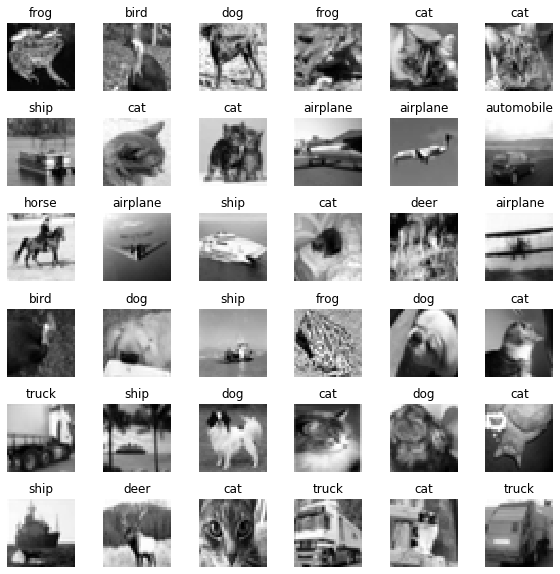

In [23]:
# Define a function to display a grid of images
def plot_images(images, labels,sz=32):
    fig, axes = plt.subplots(6, 6, figsize=(10, 10))
    axes = axes.ravel()
    for i in range(36):
        axes[i].imshow(images[i].reshape(sz, sz), cmap="gray")
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

plot_images(trainX, trainY)

### Question 1: 

---


**Apply PCA to the training portion of the dataset. How many components do you need to preserve 95% of the variance?**


---


In [24]:
pca = PCA()
pca.fit(train_images)

# Calculate the explained variance ratio for each PC
variance_ratio = pca.explained_variance_ratio_

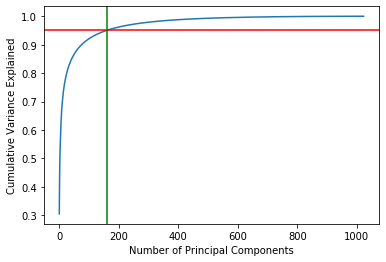

In [25]:
# Plot the scree plot
plt.plot(np.cumsum(variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')


# Add a line at 95%
plt.axhline(y=0.95, color='r', linestyle='-')
cumulative_var = np.cumsum(variance_ratio)
idx = np.argmax(cumulative_var >= 0.95)
plt.axvline(x=idx, color='g', linestyle='-')

plt.show()

In [26]:
cumulative_variance_ratio = np.cumsum(variance_ratio)
components = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
print(components)

160


*   The intersecting lines from the graph, and the above executed equation brings us to conclude that we need 160 features to explain 95% of the data variability

### Question 2:

---


**Plot 10 random images in the original form (without PCA) and then plot them after you kept 95% of variance using PCA.**


---


In [29]:
pca = PCA(n_components=160)
# Fit the PCA model to the data
pca.fit(train_images)
train_pca_X = pca.transform(train_images)

In [30]:
Reformed_train = pca.inverse_transform(train_pca_X)

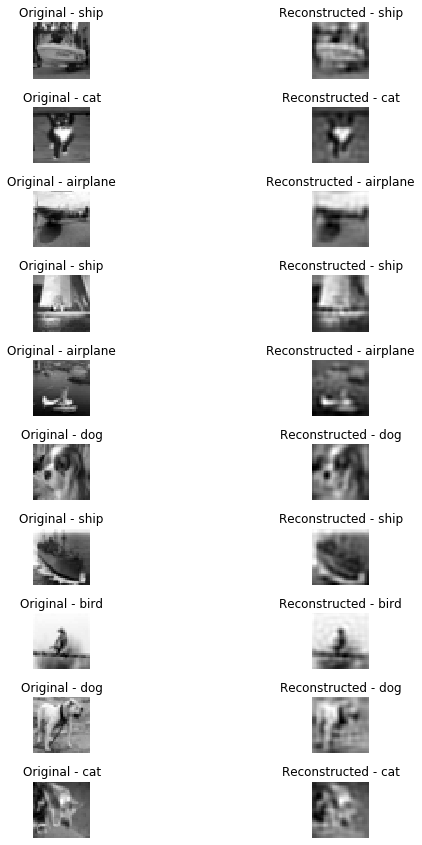

In [31]:
# Define a function to display a grid of images
class_names = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def plot_images(images, pca_images, labels,sz=32):
    indices = random.sample(range(0, len(images)), 10)
    fig, axes = plt.subplots(10, 2, figsize=(15, 15))
    
    index = 0
    for i,idx in enumerate(indices):
        axes[i][0].imshow(images[idx].reshape(sz, sz), cmap="gray")
        axes[i][0].set_title("Original - " +  class_names[labels[idx]])
        axes[i][0].axis("off")

        axes[i][1].imshow(pca_images[idx].reshape(sz, sz), cmap="gray")
        axes[i][1].set_title("Reconstructed - " + class_names[labels[idx]])
        axes[i][1].axis("off") 

    plt.subplots_adjust(hspace=0.5,wspace=-0.5)
    plt.show()

plot_images(train_images, Reformed_train, train_labels)



In [32]:
n_components = 2
pca = PCA(n_components=n_components)

# Fit PCA to the data
pca.fit(train_images)

# Calculate the percentage of variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variability by 2 components is:",sum(explained_variance_ratio))

Explained variability by 2 components is: 0.4294562488794327




*   This says that the total variation in data attributed by both components sums up to around 43%



### Question 3(A):




---


**Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?**


---



In [39]:
# Apply PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(train_images)

# Calculate the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

for i, explained_variance_ratio in enumerate(explained_variance_ratios):
    print(f"Explained Variance for Principal Component {i+1}: {explained_variance_ratio*100:.2f}%")

Explained Variance for Principal Component 1: 30.46%
Explained Variance for Principal Component 2: 12.48%


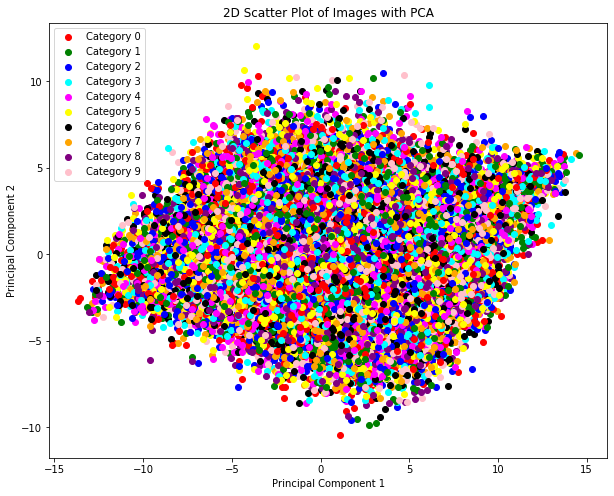

In [40]:
# Create a scatter plot
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink']


for i, category in enumerate(class_names):
    category_indices = [idx for idx, label in enumerate(class_names) if label == category]
    plt.scatter(reduced_data[category_indices, 0], reduced_data[category_indices, 1], c=colors[i], label=f'Category {category}')

# Add every rock image to the plot
for i in range(len(train_images)):
    plt.scatter(reduced_data[i, 0], reduced_data[i, 1], c=colors[i % len(colors)], marker='o')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('2D Scatter Plot of Images with PCA')
plt.show()

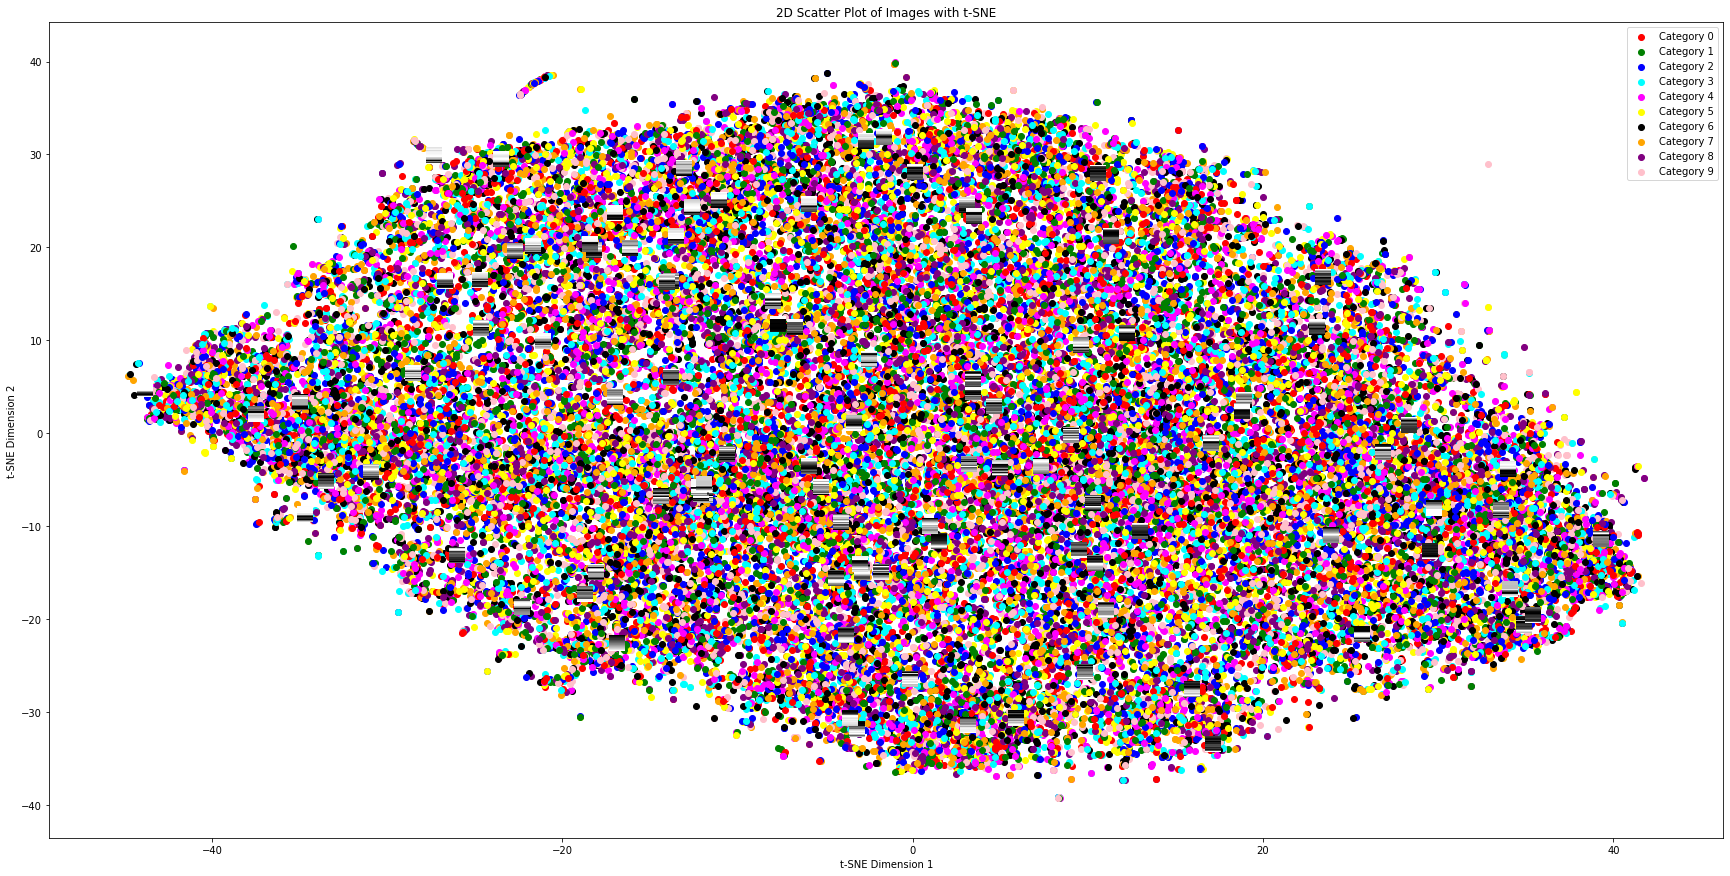

In [46]:
from matplotlib import offsetbox

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced_data_tsne = tsne.fit_transform(train_images)

plt.figure(figsize=(30, 15))

for i, category in enumerate(class_names):
    category_indices = [idx for idx, label in enumerate(class_names) if label == category]
    plt.scatter(reduced_data_tsne[category_indices, 0], reduced_data_tsne[category_indices, 1], c=colors[i], label=f'Category {category}')

# Selectively embed rock images into the plot (resized to a small size)
for i in range(len(train_images)):
    # Condition to selectively embed only some images
    # Adjusting the condition every 500th image because the dataset is huge
    if i % 500 == 0:  
        image = train_images[i]
        small_image = cv2.resize(image, (16, 16), interpolation=cv2.INTER_AREA)  # Resize to a smaller size

        # Create an AnnotationBbox for each small image
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(small_image, cmap='gray'),  # Use 'gray' for grayscale images
            (reduced_data_tsne[i, 0], reduced_data_tsne[i, 1]),  # Coordinates for the image
            boxcoords="data",
            frameon=False,
        )
        plt.gca().add_artist(imagebox)
    else:
        # For non-embedded images, just plot dots
        plt.scatter(reduced_data_tsne[i, 0], reduced_data_tsne[i, 1], c=colors[i % len(colors)], marker='o')

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.title('2D Scatter Plot of Images with t-SNE')
plt.show()